In [1]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import npeb
from npeb.GLMixture import GLMixture
import itertools
from scipy.linalg import sqrtm, inv
from scipy.spatial import distance_matrix
import ot

## Data Generation

In [8]:
n = 2500
center1 = np.asarray([0.5, 0.5])
center2 = np.asarray([-0.5, -0.5])
tau2 = 0.1
sigma2 = 1.0

np.random.seed(54321)

In [9]:
centers = np.vstack([center1, center2])

def sample_latent(nsamples, var):
  classes = np.random.randint(0, 2, size = nsamples)
  indices = np.zeros((nsamples, 2))
  indices[np.arange(nsamples), classes] = 1
  Theta = np.random.normal(indices@centers, np.sqrt(var))
  return Theta

In [10]:
Theta = sample_latent(n, tau2)
prec = np.ones_like(Theta)/sigma2
prec_smooth = 1./(1./prec + tau2)
Z = np.random.normal(Theta, np.sqrt(sigma2), size = (n, 2))
L = np.max(Z)

## Compute denoisers

### Oracle Bayes

In [6]:
ob_model = GLMixture(prec_type='diagonal')
n_supp = 10000 # number of (empirical) support points to have for the oracle prior
supp = sample_latent(n_supp,tau2) # this defines the (empirical) (oracle) prior support 
ob_model.set_params(atoms=supp, weights=np.ones(n_supp)/n_supp)
ob_means = ob_model.posterior_mean(Z, prec)
ob_indices, ob_samples = ob_model.posterior_sample(Z, prec, n_samples=2500)

### Empirical Bayes


First, we do empirical Bayes denoising with `prec_smooth`. Using `prec_smooth` pools the variances of $Z \mid \Theta$ and $\Theta \mid \mu$, and hence tries to estimate $H$, the prior/mixing measure for $\mu$, which are the cluster means. In the original data, the mixing measure places equal weight on the two possible values of $\mu$, which are $(0.5, 0.5)$ and $(-0.5, -0.5)$.

In [11]:
eb_model_h = GLMixture(prec_type='diagonal')
eb_model_h.fit(Z, prec_smooth)

Selecting all data points as atoms: done.
Computing kernel matrix: done.
Solving for discretized NPMLE: done.


[np.float64(-3.1143970518018405),
 np.float64(-3.114394039468885),
 np.float64(-3.114391600076302),
 np.float64(-3.114389509122874),
 np.float64(-3.1143876941156328),
 np.float64(-3.1143861060896483),
 np.float64(-3.1143847087732617),
 np.float64(-3.1143834737320653),
 np.float64(-3.114382377871828),
 np.float64(-3.114381402011154),
 np.float64(-3.114380529990629)]

Using the estimated prior $\hat{H}$ of $\mu$, we wish to find the estimated prior $\hat{G}(\hat{H})$ of $\Theta$. To plot this estimated prior, we will draw samples of $\mu$ according to their estimated _prior_ weights and then add $\mathcal{N}(0, \tau^2)$ noise.

In [12]:
h_hat_supp = eb_model_h.atoms
h_hat_weights = eb_model_h.weights
# sample n = 2500 points from h_hat_supp with weights h_hat_weights and then add gaussian noise of tau^2 to get (discrete) estimated prior.
n = 2500
g_hat_samples = np.zeros((n, 2))
for i in range(n):
    idx = np.random.choice(len(h_hat_supp), p=h_hat_weights)
    h_hat_sample = h_hat_supp[idx]
    g_hat_samples[i] = h_hat_sample + np.random.normal(0, np.sqrt(tau2), size=2)

Now, we want to draw samples from the posterior of $\Theta$ using linear shrinkage between the posterior for $\mu$ and the samples $Z$. We draw $\mu$ from the posterior given $Z$ or use the posterior mean for $\mu$ (resp.). For the second, we can directly plug in the posterior mean for $\mu$ by combining like terms. To draw from the mixture posterior, we use sampling with replacement over the $Z_i$. We first sample a $Z_i$, for which we then sample $\mu_i$ from the posterior of $\mu_i \mid Z_i$, and then perform the linear shrinkage using the $Z_i$, which gives us the posterior mean for $\Theta_i$. We then add the appropriate ($\sigma^2\tau^2 / (\sigma^2 + \tau^2))$ Gaussian noise.

In [21]:
eb_indices_h, h_samples = eb_model_h.posterior_sample(Z, prec_smooth, n_samples=2500)
eb_means_h = eb_model_h.posterior_mean(Z, prec_smooth)
post_theta_means = eb_means_h * sigma2 / (sigma2 + tau2) + Z * tau2 / (sigma2 + tau2)
post_theta_samples = h_samples * sigma2 / (sigma2 + tau2) + Z[eb_indices_h, :] * tau2 / (sigma2 + tau2) + np.random.normal(0, np.sqrt((sigma2 * tau2) / (sigma2 + tau2)), size=h_samples.shape)

Now, we wish to estimate the prior $G$ for $\Theta$ directly, which we do by using `prec` instead of `prec_smooth`. This does not work so well: NPMLE favors discrete and small support, soe the estimated prior $\hat{G}$ looks like the estimated prior for $\hat{H}$. Therefore, the empirical Bayes denoisers have overshrunk mean and samples from the mixture posterior are concentrated on the small estimated support.

In [17]:
eb_model_g = GLMixture(prec_type='diagonal')
eb_model_g.fit(Z, prec)
est_prior_weights_g, g_samples = eb_model_g.posterior_sample(Z, prec, n_samples=2500)
eb_means_g = eb_model_g.posterior_mean(Z, prec)

Selecting all data points as atoms: done.
Computing kernel matrix: done.
Solving for discretized NPMLE: done.


In [18]:
est_g = eb_model_g.atoms
est_g_weights = eb_model_g.weights

## Plotting

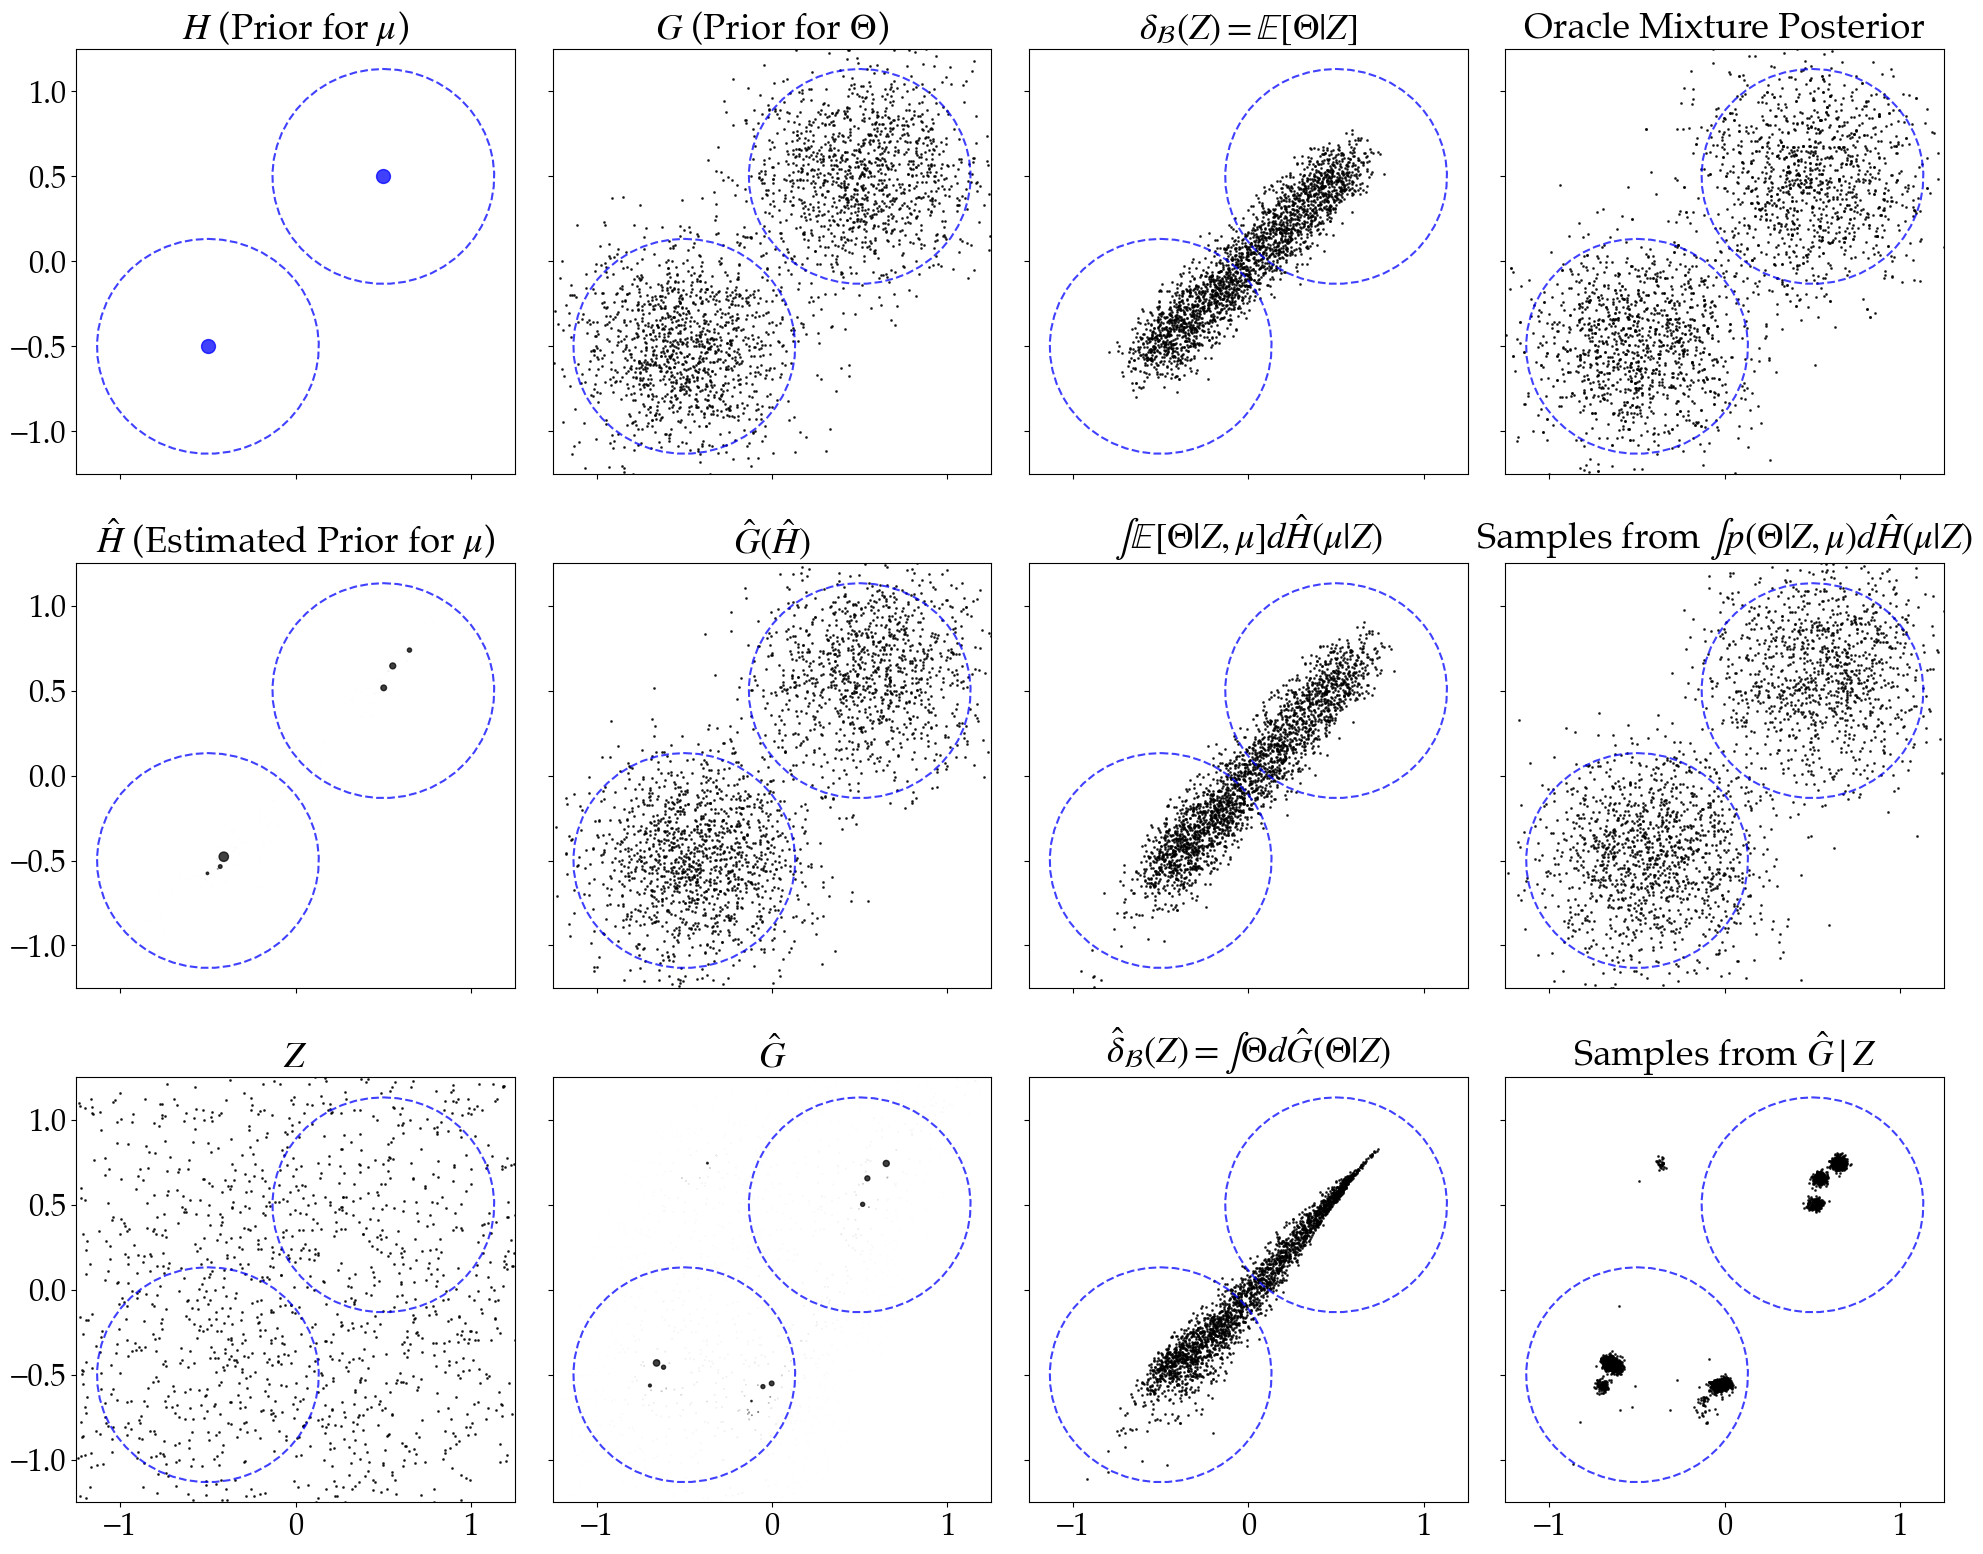

In [34]:
plt.rcParams.update({'font.size': 22, 'mathtext.fontset': 'stix', 'font.family': 'serif', 'font.serif': 'Palatino'})
fig, ax = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(20,16))
Z_alpha = 0.75
Z_s = 1.0
H_s = 100
G_alpha = 0.5

ax[0,0].set_title(r'$H$ (Prior for $\mu$)')
ax[0,0].scatter(centers[:,0], centers[:,1], s=H_s,color='blue', alpha=Z_alpha)

ax[0,1].set_title(r'$G$ (Prior for $\Theta$)')
ax[0,1].scatter(Theta[:,0], Theta[:,1], s=Z_s,color='black', alpha=Z_alpha)

ax[0,2].set_title(r'$\delta_{\mathcal{B}}(Z) = \mathbb{E}[\Theta | Z]$')
ax[0,2].scatter(ob_means[:,0], ob_means[:,1], s=Z_s,color='black', alpha=Z_alpha)

ax[0,3].set_title(r'Oracle Mixture Posterior')
ax[0,3].scatter(ob_samples[:,0], ob_samples[:,1], s=Z_s,color='black', alpha=Z_alpha)

ax[1,0].set_title(r'$\hat{H}$ (Estimated Prior for $\mu$)')
ax[1,0].scatter(eb_model_h.atoms[:,0], eb_model_h.atoms[:,1], s=eb_model_h.weights*H_s,color='black', alpha=Z_alpha)

ax[1,1].set_title(r'$\hat{G}(\hat{H})$')
ax[1,1].scatter(g_hat_samples[:,0], g_hat_samples[:,1], s=Z_s,color='black', alpha=Z_alpha)

ax[1,2].set_title(r'$\int \mathbb{E}[\Theta|Z, \mu] d\hat{H}(\mu | Z)$')
ax[1,2].scatter(post_theta_means[:,0], post_theta_means[:,1], s=Z_s,color='black', alpha=Z_alpha)

ax[1,3].set_title(r'Samples from $\int p(\Theta|Z, \mu) d\hat{H}(\mu | Z)$')
ax[1,3].scatter(post_theta_samples[:,0], post_theta_samples[:,1], s=Z_s,color='black', alpha=Z_alpha)

ax[2,0].set_title(r'$Z$')
ax[2,0].scatter(Z[:,0], Z[:,1], s=Z_s,color='black', alpha=Z_alpha)

ax[2,1].set_title(r'$\hat{G}$')
ax[2,1].scatter(est_g[:,0], est_g[:,1], s=est_g_weights*H_s,color='black', alpha=Z_alpha)

ax[2,2].set_title(r'$\hat{\delta}_{\mathcal{B}}(Z) = \int \Theta d\hat{G}(\Theta | Z)$')
ax[2,2].scatter(eb_means_g[:,0], eb_means_g[:,1], s=Z_s,color='black', alpha=Z_alpha)

ax[2,3].set_title(r'Samples from $\hat{G} \mid Z$')
ax[2,3].scatter(g_samples[:,0] + 0.02*np.random.randn(g_samples.shape[0]), g_samples[:,1] + 0.02*np.random.randn(g_samples.shape[0]), s=Z_s,color='black', alpha=Z_alpha)


u = np.linspace(0,2*np.pi)
circ1 = center1 + 2*np.sqrt(tau2)*np.vstack([np.sin(u),np.cos(u)]).T
circ2 = center2 + 2*np.sqrt(tau2)*np.vstack([np.sin(u),np.cos(u)]).T
for i in range(3):
    for j in range(4):
        # if i > 0 or j > 0:
        ax[i,j].plot(circ1[:,0],circ1[:,1],color='blue',linestyle='dashed', alpha=0.75)
        ax[i,j].plot(circ2[:,0],circ2[:,1],color='blue',linestyle='dashed', alpha=0.75)
            # ax[i,j].scatter(Theta[:,0], Theta[:,1], s=Z_s,color='blue', alpha=G_alpha)

plt.xlim([-1.25,1.25])
plt.ylim([-1.25, 1.25])
plt.tight_layout()
